In [152]:
!git clone https://github.com/YasirHabib/The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning.git

fatal: destination path 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning' already exists and is not an empty directory.


In [153]:
!ls The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [0]:
path = 'The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data'
train_dir = os.path.join(path, 'driving_log.csv')

In [157]:
df_data = pd.read_csv(train_dir, header = None)
df_data.head()

,0,1,2,3,4,5,6
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000082


In [158]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df_data = pd.read_csv(train_dir, names = columns)
df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000081
1,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
2,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
3,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000078
4,C:\Laptop\GitHub\The-Complete-Self-Driving-Car...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,C:\Laptop\GitHub\The-Complete-Self-Driving-Ca...,0.0,0.0,0.0,0.000082


In [159]:
def path_split(path):
  head, tail = ntpath.split(path)
  return tail

df_data['center'] = df_data['center'].apply(path_split)
df_data['left'] = df_data['left'].apply(path_split)
df_data['right'] = df_data['right'].apply(path_split)

df_data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_11_30_13_10_08_292.jpg,left_2019_11_30_13_10_08_292.jpg,right_2019_11_30_13_10_08_292.jpg,0.0,0.0,0.0,0.000081
1,center_2019_11_30_13_10_08_402.jpg,left_2019_11_30_13_10_08_402.jpg,right_2019_11_30_13_10_08_402.jpg,0.0,0.0,0.0,0.000078
2,center_2019_11_30_13_10_08_508.jpg,left_2019_11_30_13_10_08_508.jpg,right_2019_11_30_13_10_08_508.jpg,0.0,0.0,0.0,0.000078
3,center_2019_11_30_13_10_08_609.jpg,left_2019_11_30_13_10_08_609.jpg,right_2019_11_30_13_10_08_609.jpg,0.0,0.0,0.0,0.000078
4,center_2019_11_30_13_10_08_718.jpg,left_2019_11_30_13_10_08_718.jpg,right_2019_11_30_13_10_08_718.jpg,0.0,0.0,0.0,0.000082


[ 130    6    1   17   74   17    3   23  323   49    2   63 3612   42
    0   19  163   34    1   16   42   20    1    0   81]
[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


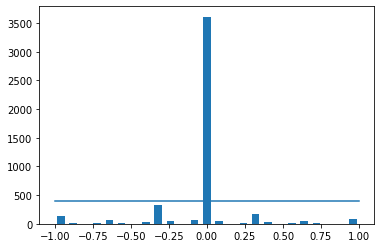

In [160]:
num_bins = 25
hist, bins = np.histogram(df_data['steering'], num_bins)   # bins is the interval across which the data is distributed
print(hist)
print(bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(center)
plt.bar(center, hist, width=0.05)
samples_per_bin = 400
plt.plot((np.min(df_data['steering']), np.max(df_data['steering'])), (samples_per_bin, samples_per_bin))

In [161]:
# print('total data:', len(df_data))                        total data: 4739
# print ('steering data:', len(df_data['steering']))        steering data: 4739

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df_data['steering'])):
    if df_data['steering'][i] >= bins[j] and df_data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  # print(len(list_))             0 0 0 0 0 0 0 0 0 0 0 0 3212 0 0 0 0 0 0 0 0 0 0 0 0
  remove_list.extend(list_)

print('removed:', len(remove_list))        # 3612 - 400
df_data.drop(df_data.index[remove_list], inplace=True)
print('remaining:', len(df_data))

removed: 3212
remaining: 1527


[130   6   1  17  74  17   3  23 323  49   2  63 400  42   0  19 163  34
   1  16  42  20   1   0  81]


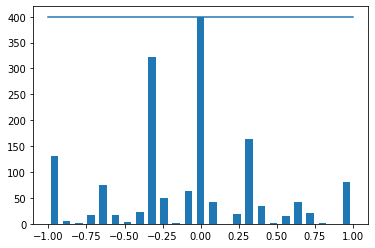

In [162]:
hist, _ = np.histogram(df_data['steering'], num_bins)
print(hist)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df_data['steering']), np.max(df_data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
# print(df_data.iloc[0])

# center      center_2019_11_30_13_10_08_402.jpg
# left          left_2019_11_30_13_10_08_402.jpg
# right        right_2019_11_30_13_10_08_402.jpg
# steering                                     0
# throttle                                     0
# reverse                                      0
# speed                              7.75008e-05
# Name: 1, dtype: object

Training Samples: 1221
Valid Samples: 306


Text(0.5, 1.0, 'Validation set')

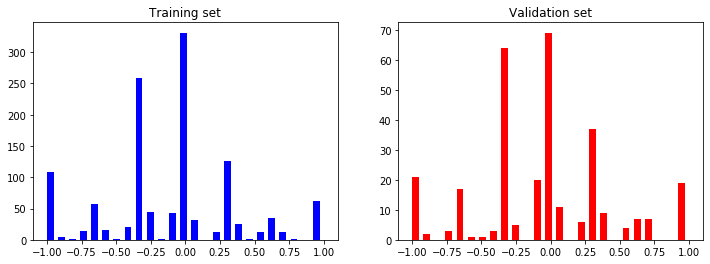

In [164]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    # print(len(df))         # 1527

    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # print(center)              center_2019_11_30_13_10_08_402.jpg
    image_path.append(os.path.join(datadir, center.strip()))
    # print(image_path[0])       The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data/IMG/center_2019_11_30_13_10_08_402.jpg
    steering.append(float(indexed_data[3]))
    # print(steering[0])        # 0.0

  # print(image_path[0].shape)    AttributeError: 'str' object has no attribute 'shape'
  # print(steering[0].shape)      AttributeError: 'float' object has no attribute 'shape'

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  # print(image_paths[0])         The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data/IMG/center_2019_11_30_13_10_08_402.jpg
  # print(steerings[0])           0.0
  # print(image_paths[0].shape)   ()
  # print(steerings[0].shape)     ()

  return image_paths, steerings

image_paths, steerings = load_img_steering(path + '/IMG', df_data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [165]:
print(image_paths.shape, steerings.shape)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(1527,) (1527,)
(1221,) (306,) (1221,) (306,)


Text(0.5, 1, 'Preprocessed Image')

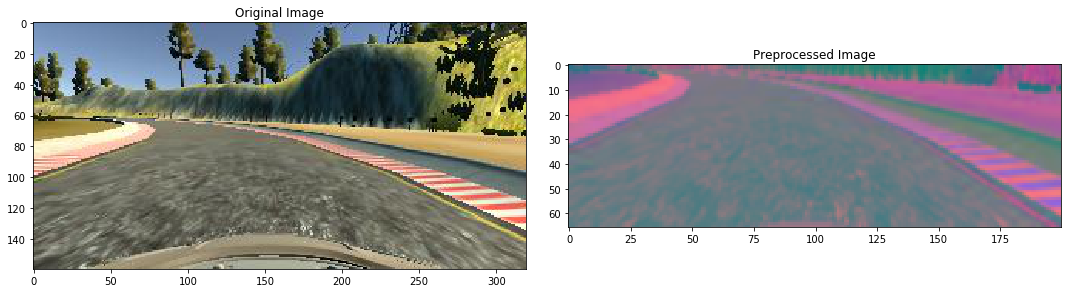

In [166]:
def augmentation(image, steering_angle):

  image = mpimg.imread(image)

  if np.random.rand() < 0.5:
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)

  if np.random.rand() < 0.5:
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)

  if np.random.rand() < 0.5:
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)

  if np.random.rand() < 0.5:
    image = cv2.flip(image,1)
    steering_angle = -steering_angle

  return image, steering_angle

def preprocess_steps(image):
  image = image[60:140, :, :]
  # print(image.shape)                    (80, 320, 3)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Nvidia model recommends using YUV colorspace over dataset. Consists of 3 channels like RGB
                                                 # Y represents the luminosity or brightness, UV components represent chromiums which add color 2 the img
  image = cv2.GaussianBlur(image, (3,3), 0)
  image = cv2.resize(image, (200, 66))
  # print(image.shape)                    (66, 200, 3)
  image = image/255

  return image

image = image_paths[0]
# print(image)                            The-Complete-Self-Driving-Car-Course---Applied-Deep-Learning/Data/IMG/center_2019_11_30_13_10_08_402.jpg
# print(image.shape)                      ()
original_image = mpimg.imread(image)
# print(original_image.shape)             (160, 320, 3)
preprocessed_image = preprocess_steps(original_image)
# print(preprocessed_image.shape)         (66, 200, 3)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(images, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = np.random.randint(0, len(images) - 1)

      if istraining:
        im, steering = augmentation(images[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(images[random_index])
        steering = steering_ang[random_index]

      im = preprocess_steps(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))     # default stride=(1,1)
  model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error',
                optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
                metrics=['accuracy']
                )
  
  return model

In [169]:
model = nvidia_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)              

In [170]:
r = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=15,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle = True
    )

Epoch 1/15
300/300 [==============================] - 225s 750ms/step - loss: 0.1951 - acc: 0.2717 - val_loss: 0.1358 - val_acc: 0.2618
Epoch 2/15
300/300 [==============================] - 219s 729ms/step - loss: 0.1528 - acc: 0.2998 - val_loss: 0.1228 - val_acc: 0.2801
Epoch 3/15
300/300 [==============================] - 218s 728ms/step - loss: 0.1276 - acc: 0.3147 - val_loss: 0.1038 - val_acc: 0.2928
Epoch 4/15
300/300 [==============================] - 217s 724ms/step - loss: 0.1129 - acc: 0.3297 - val_loss: 0.0920 - val_acc: 0.2926
Epoch 5/15
300/300 [==============================] - 219s 729ms/step - loss: 0.1019 - acc: 0.3299 - val_loss: 0.0782 - val_acc: 0.2929
Epoch 6/15
300/300 [==============================] - 220s 734ms/step - loss: 0.0961 - acc: 0.3417 - val_loss: 0.0792 - val_acc: 0.3051
Epoch 7/15
300/300 [==============================] - 219s 729ms/step - loss: 0.0903 - acc: 0.3364 - val_loss: 0.0663 - val_acc: 0.3101
Epoch 8/15
300/300 [============================

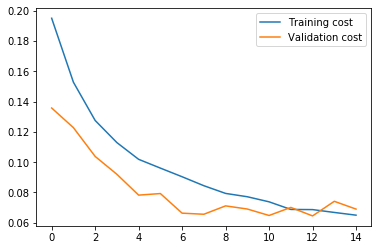

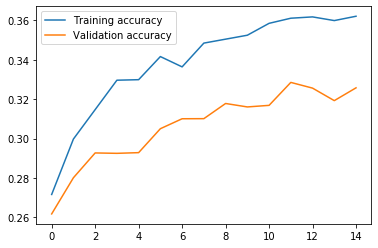

In [171]:
plt.plot(r.history['loss'], label='Training cost')
plt.plot(r.history['val_loss'], label='Validation cost')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='Training accuracy')
plt.plot(r.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.show()

In [0]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')